In [40]:
from __future__ import division

from math import sqrt, cos, sin, acos, pi, atan2
from matplotlib import cm
from matplotlib import patches
from matplotlib.colors import LogNorm
from matplotlib.path import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import json

import sphereml
from scipy.optimize import differential_evolution
from pyfde import JADE
%run algorithms/genetic.py
import lcmaes
import time
import functions

from persistence import save, load
from joblib import Parallel, delayed
import pyformulas as pf

factor = 1.3

In [41]:
def run_evaluation(func_n, dims, algo, n_it, popsize=None, sbbx_eta=1.0, log=False, corrupt_first_guess=False, 
                   seed=283636):
    # TODO: use seed everywhere
    func = getattr(functions, f"f{func_n}")
    lb = functions.lbound[func_n - 1]
    rb = functions.rbound[func_n - 1]
    
    def magic_cast(a):
        if type(a) is np.ndarray:
            return a
        else:
            return np.array(a)
    
    def helper(ind):
        helper.calls += 1
        return -func(magic_cast(ind))
    helper.calls = 0
    
    hist = []
    limits = [(lb, rb)]*dims
    
    if popsize is None: popsize = 5*len(limits)
    if popsize > n_it: raise AssertionError(f"popsize({popsize}) should be < n_it({n_it})")
    
    def gen_callback(fitness):
        hist.append((helper.calls, fitness))
        #print("hist: {} {}".format(len(hist), hist[-1]))
        if helper.calls > n_it:
            return True
    
    if algo == 'JADE':
        solver = JADE(helper, n_dim=len(limits), n_pop=popsize, limits=limits)
        for _ in range(int(n_it/popsize)):
            best, fit = solver.run(n_it=1)
            hist.append((helper.calls, fit))
            
    elif algo == 'DE':
        def de_callback(xk, convergence):
            hist.append((helper.calls, -func(magic_cast(xk))))
            if helper.calls > n_it:
                return True
        
        result = differential_evolution(lambda t: -helper(t), limits,
                               callback=de_callback, popsize=popsize, maxiter=n_it)
        best, fit = result.x, -result.fun
    
    elif algo == 'genetic':
        best, fit = genetic(helper,
                            limits=limits, popsize=popsize, generations=n_it, sbbx_eta=sbbx_eta, log=False,
                            callback=gen_callback)
    elif algo == '1+1':
        best, fit = one_plus_one(helper, limits=limits, log=False, callback=gen_callback)
    elif algo == 'CMA':
        str_algo=b'acmaes'
        # the optimum should better not be far away from the interval [x0 - sigma0, x0 + sigma0] in each dimension
        if corrupt_first_guess:
            x0 = [(rb + lb) / 3] * dims
            sigma0 = (rb - lb) / 2
        else:
            x0 = [(rb + lb) / 2] * dims
            sigma0 = (rb - lb) / 2

        # without scaling (see lcmaes_interface.py). affects both parameters and optimization function
        gp = lcmaes.make_genopheno_pwqb([lb]*dims,[rb]*dims,dims)
        p = lcmaes.make_parameters_pwqb(x0,sigma0,gp)
        p.set_str_algo(str_algo)
        #p.set_quiet(False)
        objfunc = lcmaes.fitfunc_pbf.from_callable(lambda x, n: -helper(x))
        
        def pfunc_raw(fitness):
            if np.isnan(fitness):
                return 0
            hist.append((helper.calls, -fitness))
            if helper.calls > n_it:
                #print("STOP")
                return 1
            return 0
        
        pfunc = lcmaes.pfunc_pbf.from_callable(pfunc_raw)
        
        results = lcmaes.pcmaes_pwqb2(objfunc, p, pfunc)
        bestie = results.best_candidate()
        
        fit, best = -bestie.get_fvalue(), lcmaes.get_candidate_x(bestie)
    else:
        raise AssertionError("Unknown algo")
    
    if log:
        print("{}: best {} for ind {}".format(algo, fit, best))
    return best, fit, hist

cmabest, cmafit, cma = run_evaluation(func_n=1, dims=30, algo='CMA', n_it=100000, corrupt_first_guess=True)
print(cmafit)

-8.885729236409477e-27


In [42]:
def run_evaluations(runs=50, *args, **kwargs):
    res = []
    for run in range(runs):
        _, _, hist = run_evaluation(*args, **kwargs)
        res.append(hist)
    return np.array(res)

In [35]:
r = run_evaluations(runs=10, func_n=1, dims=30, algo='CMA', n_it=10000)

In [37]:
%%time

res = {}

for (n_it, dims) in [(50000, 30), (100000, 100)]:
    res[dims] = {}
    for func_n in range(1, 14):
        res[dims][func_n] = {}
        print(f"{dims} f{func_n}")
        for algo in ['JADE', 'CMA', 'genetic', '1+1']: #'DE',
            print(f"{algo}")
            if algo == 'CMA':
                RUNS=10
            else:
                RUNS=5
            r = run_evaluations(runs=RUNS, func_n=func_n, dims=dims, algo=algo, n_it=n_it, corrupt_first_guess=True)
            
            if algo == '1+1' or algo == 'CMA':
                length = min(map(len, r))
                r = np.array([np.array(xi)[:length] for xi in r])
            else:
                r = np.array(r)
            ggr=r
            
            #mean = r.mean(axis=0)
            #max_ = r.max(axis=0)
            min_ = r[0]
            for cand in r:
                if cand[-1,1] < min_[-1,1]:
                    min_=cand
            
            error = r.max(axis=0) - r.mean(axis=0)

            res[dims][func_n][algo] = (min_, error[:,1])
            
save(res, "results/f/temp_res.json")

30 f1
JADE
CMA
genetic
1+1
30 f2
JADE
CMA
genetic
1+1
30 f3
JADE
CMA
genetic
1+1
30 f4
JADE
CMA
genetic
1+1
30 f5
JADE
CMA
genetic
1+1
30 f6
JADE
CMA
genetic
1+1
30 f7
JADE
CMA
genetic
1+1
30 f8
JADE
CMA
genetic
1+1
30 f9
JADE
CMA
genetic
1+1
30 f10
JADE
CMA
genetic
1+1
30 f11
JADE
CMA
genetic
1+1
30 f12
JADE
CMA
genetic
1+1
30 f13
JADE
CMA
genetic
1+1
100 f1
JADE
CMA


KeyboardInterrupt: 

In [15]:
for (n_it, dims) in [(100000, 30), (300000, 100)]:
    for func_n in range(1, 14):
        small_res = res[dims][func_n]["CMA"]
        rest = small_res
        all_res[dims][func_n]["CMA"]= small_res

TypeError: bad operand type for unary -: 'tuple'

In [7]:
res = all_res

In [58]:
min(map(len, res[30][1]["JADE"][0]))

2

In [ ]:
for dims in [30, 100]:
    for func_n in range(1, 14):
        res[dims][func_n]['CMA']=res

In [31]:
res[100][1]['CMA'][0][:,1].min()

1.0097419586828951e-25

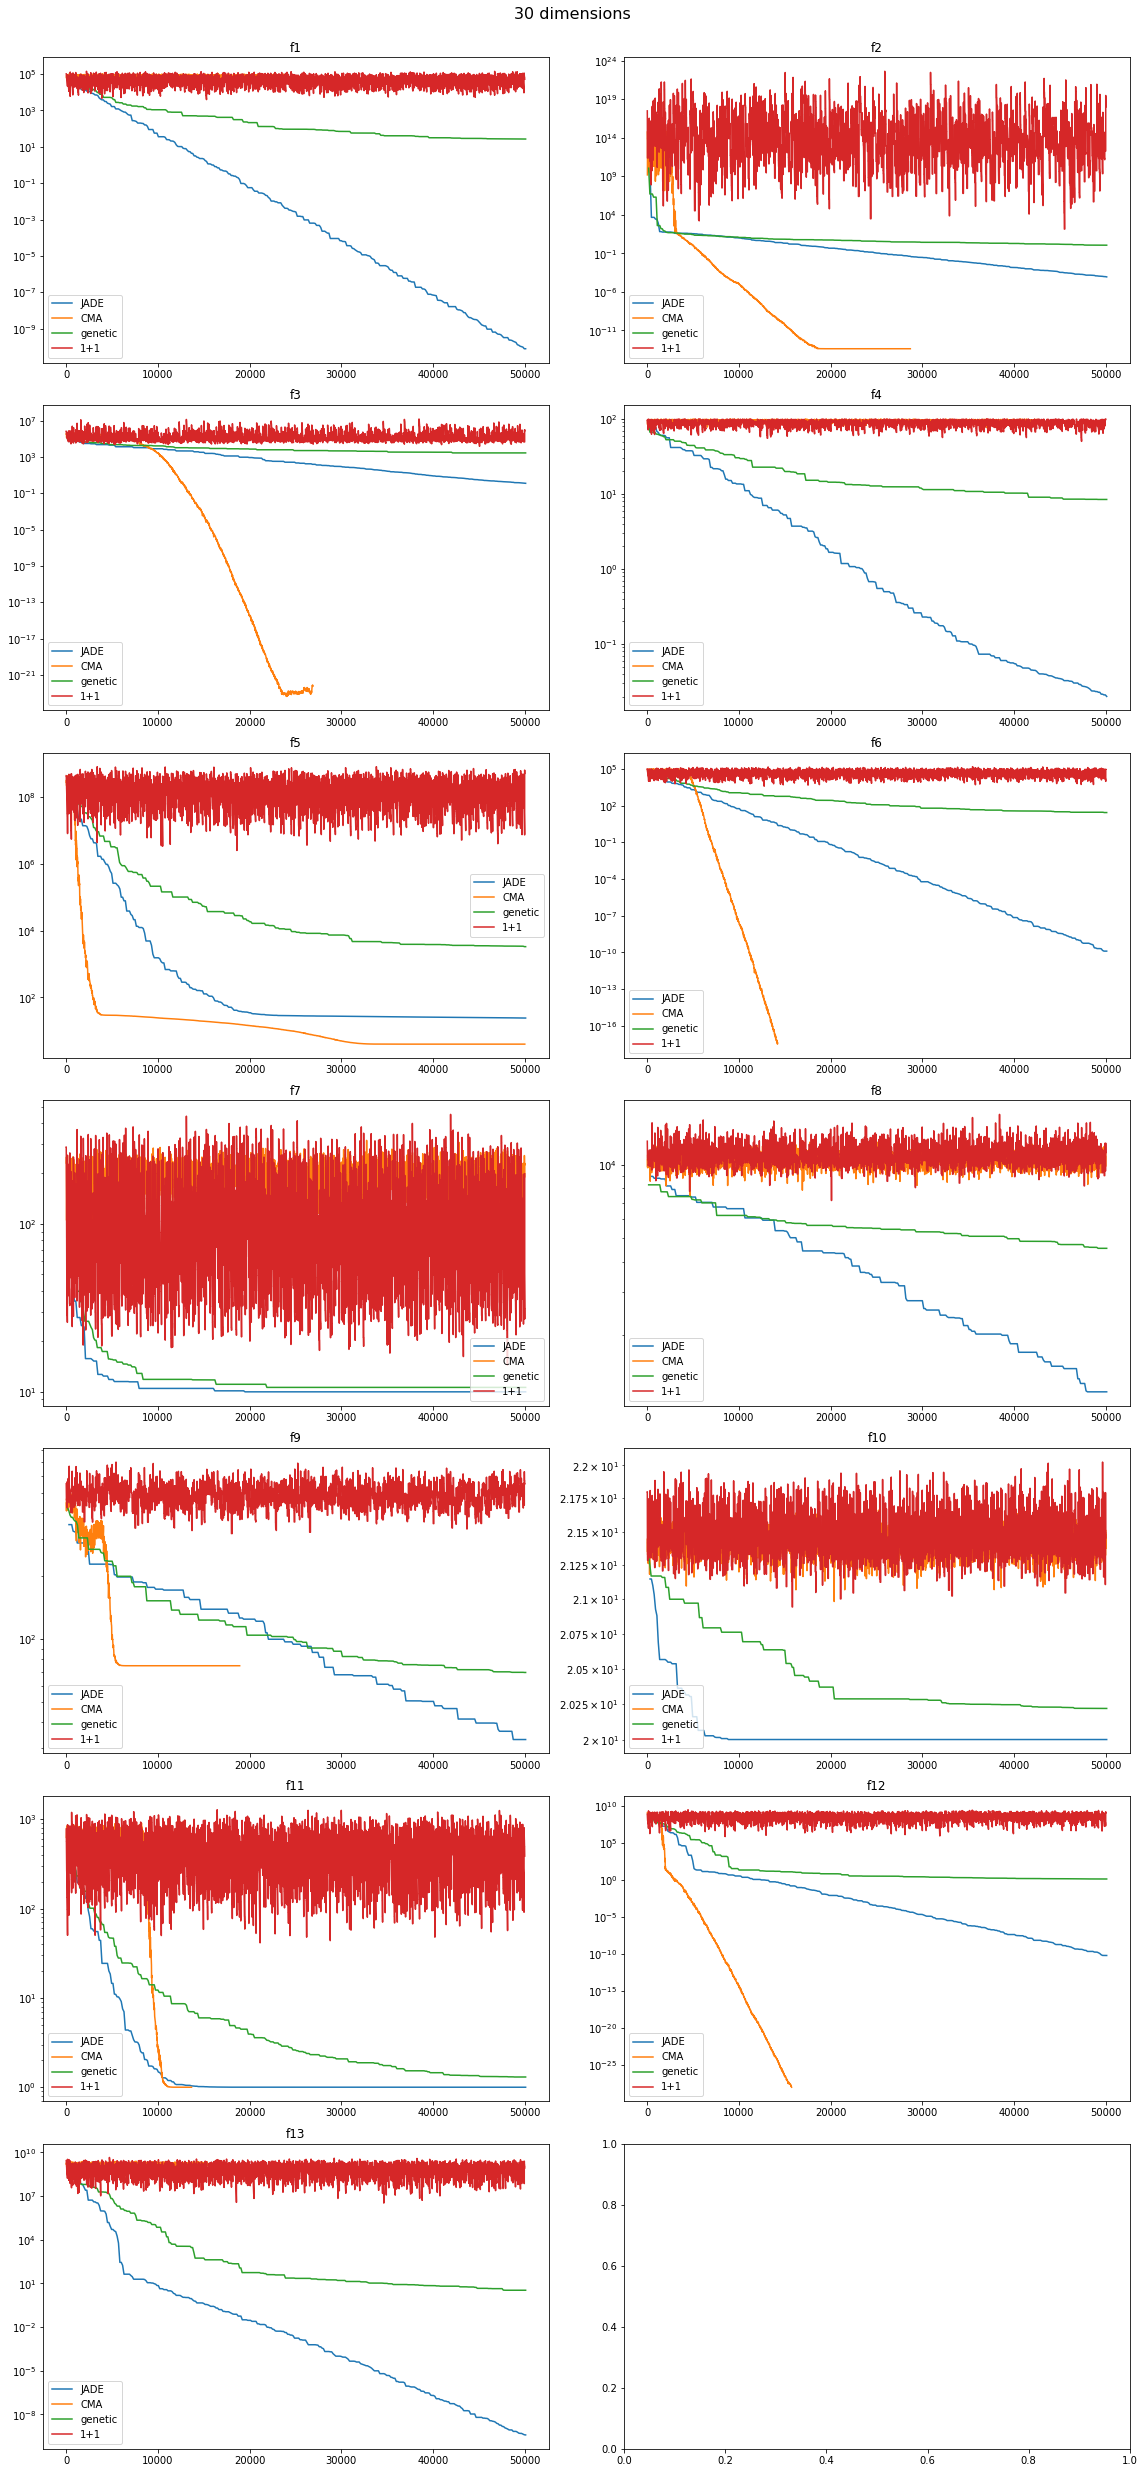

In [38]:
fig, axes = plt.subplots(7, 2, figsize=(16,5*7))

dims = 30
fig.suptitle(f'{dims} dimensions', fontsize=16)
for func_n in range(0, 13):
    ax = axes[func_n // 2, func_n % 2]
    ax.set_title(f"f{func_n + 1}")
    
    for algo in ['1+1', 'JADE', 'CMA', 'genetic']:
        r = res[dims][func_n + 1][algo]
        
        xs = r[0][:,0]
        ys = -r[0][:,1]
        error = r[1]
        if True or algo == '1+1':
            ax.plot(xs, ys, label=algo)
        else:
            ax.errorbar(xs, ys, yerr=error, fmt='-o', label=algo)
        ax.set_yscale('log')
        ax.legend();
        
fig.tight_layout()
fig.subplots_adjust(top=0.96)

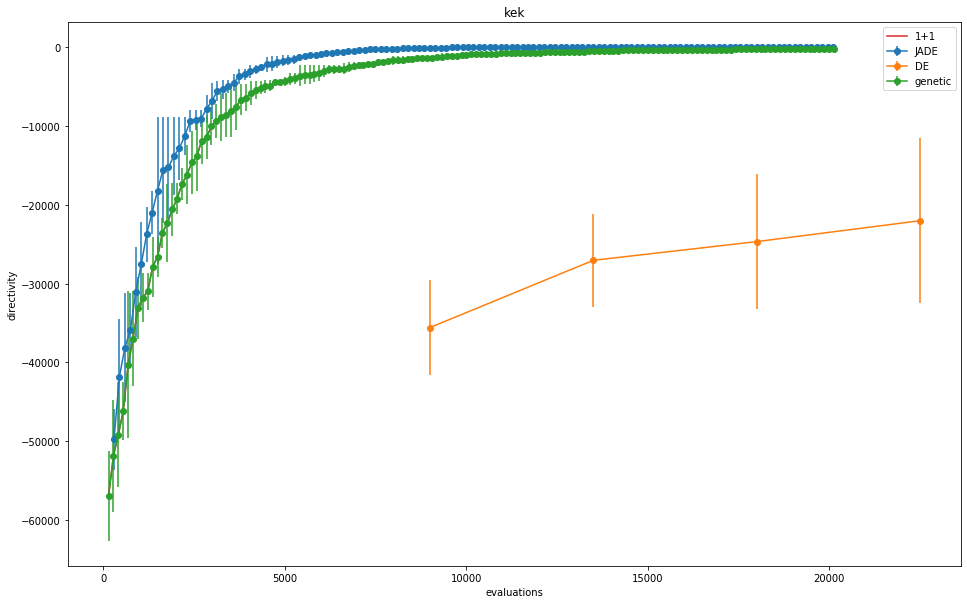

In [279]:
plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("kek")
for algo in ['JADE', 'DE', 'genetic', '1+1']:
    xs = res[30][1][algo][0][:,0]
    ys = res[30][1][algo][0][:,1]
    error = res[30][1][algo][1]
    if algo == '1+1':
        plt.plot(xs, ys, label=algo)
    else:
        plt.errorbar(xs, ys, yerr=error, fmt='-o', label=algo)
plt.legend();

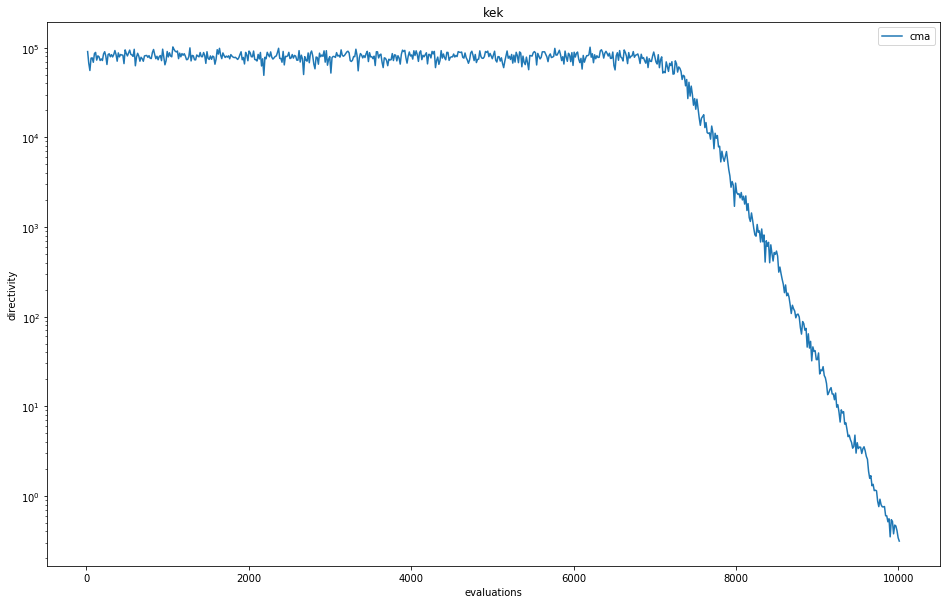

In [57]:
#_, _, genetic = run_evaluation(func_n=1, dims=30, algo='genetic', n_it=20000)
#_, _, jade = run_evaluation(func_n=1, dims=30, algo='JADE', n_it=20000)
#bestcma, fitcma, cma = run_evaluation(func_n=1, dims=30, algo='CMA', n_it=20000)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("kek")
plot_hist(cma, "cma")
plt.yscale('log')
#plot_hist(genetic, "genetic")
plt.legend();

In [26]:
limitsdict = {'r_limits':(10,120), 'm_limits':(3, 10), 'mj_limits':(0, 0.4)}

def plot_hist(hist, label, linestyle='-'):
    histarr = np.array(hist)
    xs,ys = histarr[:,0],histarr[:,1]
    plt.plot(xs, ys, linestyle=linestyle, label=label)

In [8]:
%%time

results = []
n_it=1000
retries=1
for sbbx_eta in [0.001, .01, .1, .5, 1.0, 1.5, 5.0, 10.0, 100.0]:
    kek = []
    for _ in range(retries):
        _, _, hist = run_evaluation('genetic', n_it=n_it, layers=5, sbbx_eta=sbbx_eta, log=False, **limitsdict)
        kek.append(hist[-1][1])
    print("{}: {}".format(sbbx_eta, np.array(kek).mean()))

0.001: 6.668770986783339
0.01: 6.15296404848088
0.1: 7.398712456982985
0.5: 5.940296225286354
1.0: 6.70091006966024
1.5: 5.89705486790656
5.0: 5.842585382385108
10.0: 6.4637500926907645
100.0: 6.273629389793842
CPU times: user 1min 10s, sys: 12.6 ms, total: 1min 10s
Wall time: 1min 10s


In [10]:
kek

[6.273629389793842]

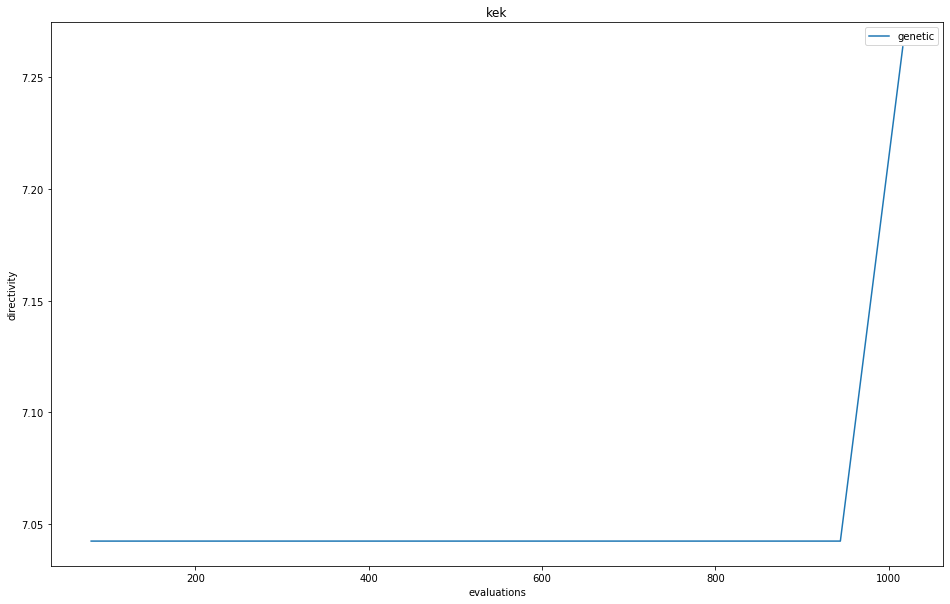

In [13]:
#_, _, hist = run_evaluation('genetic', n_it=n_it, layers=5, sbbx_eta=sbbx_eta, log=False, **limitsdict)

plt.figure(figsize=(16,10))
plt.xlabel("evaluations")
plt.ylabel("directivity")
plt.title("kek")
plot_hist(hist, "genetic")
plt.legend();